<a href="https://colab.research.google.com/github/lpoggetto/riskified_case/blob/main/riskfied_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminary analysis


In [1]:
# utilized libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importing the data (pre loaded in a github repo)

df = pd.read_csv('https://raw.githubusercontent.com/lpoggetto/riskified_case/refs/heads/main/new_dataset.csv',
                 sep = ',')

In [3]:
df.head()

,order_id,order_date,order_status,price,digital_product,customer_account_age,order_source,billing_zip,shipping_name_length,classification_score
0,906967102,2019-06-01,approved,213.88,False,0,web,33062,13,0.999219
1,906987974,2019-06-01,approved,50.00,True,0,mobile_app,48317,0,0.995886
2,906994260,2019-06-01,approved,100.00,True,328,web,92124,0,0.966901
3,906997653,2019-06-01,approved,25.00,True,1371,web,95448,0,0.999854
4,907408483,2019-06-01,approved,2035.76,False,139,web,61107,17,0.999965


In [4]:
# checking basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40825 entries, 0 to 40824
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              40825 non-null  int64  
 1   order_date            40825 non-null  object 
 2   order_status          40825 non-null  object 
 3   price                 40825 non-null  float64
 4   digital_product       40825 non-null  bool   
 5   customer_account_age  40825 non-null  int64  
 6   order_source          40825 non-null  object 
 7   billing_zip           40825 non-null  object 
 8   shipping_name_length  40825 non-null  int64  
 9   classification_score  40825 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(4)
memory usage: 2.8+ MB


In [5]:
print('period of analysis:')
print(min(df['order_date']),'-',max(df['order_date']))

period of analysis:
2019-06-01 - 2019-07-01


In [6]:
def create_freq_table(df, column_name, sort_by='frequency', ascending=False,
                      round_decimals=2, include_percentage=True):

    # Calculate frequencies
    freq = df[column_name].value_counts()

    # Create result DataFrame
    result = pd.DataFrame({'frequency': freq})

    # Add percentage if requested
    if include_percentage:
        percent = df[column_name].value_counts(normalize=True) * 100
        result['percentage'] = percent.round(round_decimals)

    # Sort results
    if sort_by in result.columns:
        result = result.sort_values(by=sort_by, ascending=ascending)

    return result

In [7]:
freq_table_order_status = create_freq_table(df, 'order_status')
freq_table_order_status

,frequency,percentage
order_status,,
approved,40465,99.12
chargeback,360,0.88


In [8]:
freq_table_digital_product = create_freq_table(df, 'digital_product')
freq_table_digital_product

,frequency,percentage
digital_product,,
True,27287,66.84
False,13538,33.16


In [9]:
freq_table_order_source = create_freq_table(df, 'order_source')
freq_table_order_source

,frequency,percentage
order_source,,
web,40151,98.35
mobile_app,674,1.65


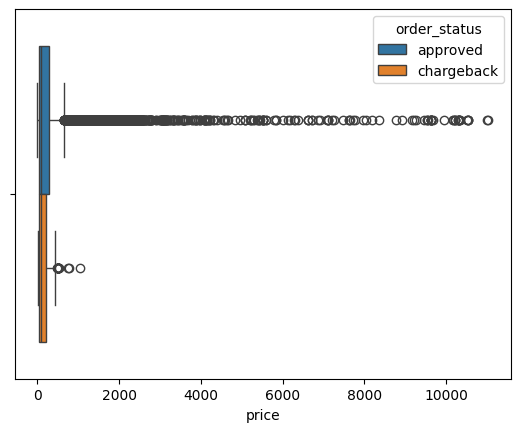

In [10]:
sns.boxplot(data=df,
            x='price',
            hue='order_status');

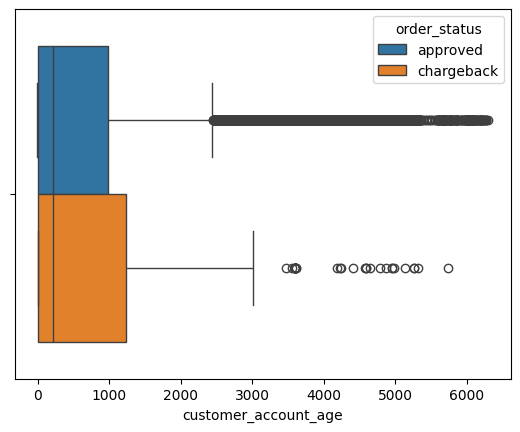

In [11]:
sns.boxplot(data=df,
            x='customer_account_age',
            hue='order_status');

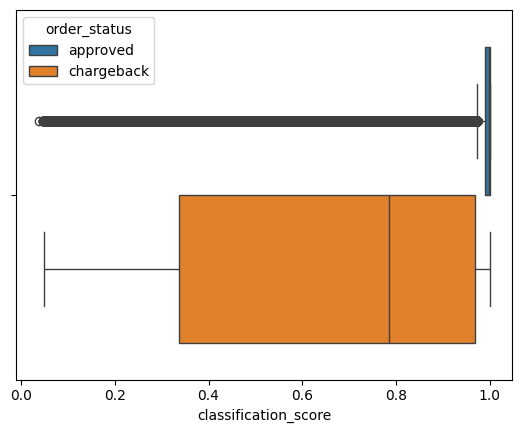

In [12]:
sns.boxplot(data=df,
            x='classification_score',
            hue='order_status');

## Task 1

### Rely exclusively on model scores, and set a decline threshold that will provide a 90% approval rate

In [20]:
# utilized libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# importing the data (pre loaded in a github repo)

df = pd.read_csv('https://raw.githubusercontent.com/lpoggetto/riskified_case/refs/heads/main/new_dataset.csv',
                 sep = ',')

In [22]:
# Compute the 10th percentile threshold
decline_threshold = np.percentile(df['classification_score'], 10)

# Using the bottom 10% of the classification score distribuition, aiming for a 90% approval rate.
print(f'Decline threshold: {decline_threshold:.4f}')

Decline threshold: 0.8608


### Checking the amount of orders that would be refused.

In [16]:
# Count total approved orders before applying the threshold
total_approved_before = len(df)

# Count how many approved orders will now be declined
newly_declined = (df['classification_score'] < decline_threshold).sum()

# Compute remaining approved orders
remaining_approved = total_approved_before - newly_declined

impact_table = pd.DataFrame({
    "Metric": ["Total Approved Before", "Newly Declined Orders", "Remaining Approved"],
    "Count": [total_approved_before, newly_declined, remaining_approved]
})

impact_table

,Metric,Count
0,Total Approved Before,40825
1,Newly Declined Orders,4083
2,Remaining Approved,36742


## Task 2

 ### Plot the model scores distribution

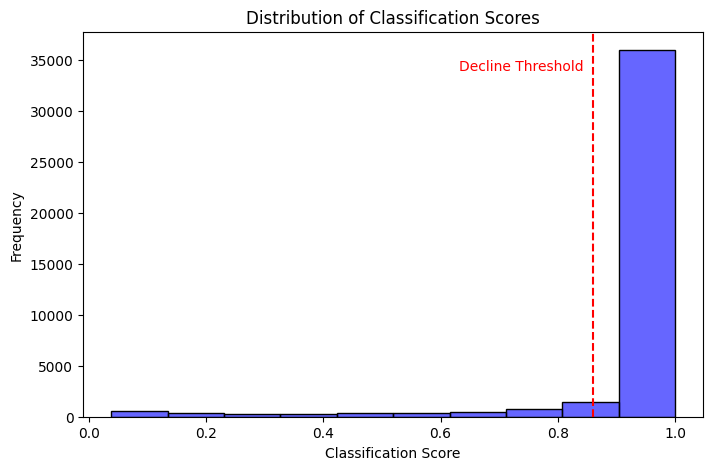

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(df['classification_score'], bins=10, color='blue', alpha=0.6)
plt.axvline(x=decline_threshold, color='red', linestyle='--')
plt.text(decline_threshold - 0.23, plt.ylim()[1] * 0.9, 'Decline Threshold', color='red')
plt.xlabel("Classification Score")
plt.ylabel("Frequency")
plt.title("Distribution of Classification Scores")
plt.show()

## Task 3

### Assuming we aim at a proportion of 50% between the CHB cost and the total revenue (sum amount of CHBs divided by the total revenue), what would have to be the fee?

In [18]:
# price by order status
df.groupby(["order_status"])['price'].sum()

,price
order_status,
approved,16122719.73
chargeback,48637.12


In [19]:
# Total number of approved orders
total_orders = len(df['order_id'])

# Compute total revenue (sum of all approved order prices)
total_revenue = df["price"].sum()

# Compute total CHB cost (sum of all chargeback order prices)
chb_cost = df[df["order_status"] == "chargeback"]["price"].sum()

# Compute required fee per order to meet the 50% CHB cost proportion
fee_per_order = (total_revenue/chb_cost) * 0.5

print(f'Estimated fee: {fee_per_order:.2f}')

Estimated fee: 166.25
